# <center>LightFM

In [ ]:
!pip install lightfm
!pip install pandas
!pip install scipy

import pandas as pd
from scipy.sparse import csr_matrix
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k, recall_at_k

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=808333 sha256=7213554938ab33683ce48f2ce399361024d8d55254e9016f29f8d21c229a56f2
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [ ]:
ratings = pd.read_csv('ratings.csv') # Поставленные оценки
books = pd.read_csv('books.csv') # Информация о книгах
tags = pd.read_csv('tags.csv') # Информация о тегах
book_tags = pd.read_csv('book_tags.csv') # Книги с тегами

Сначала посмотрим на набор данных `books`: в этих данных есть обычный `id` книги, а есть `id` книги в системе `Goodreads` — этот `id` отображён в признаке `goodreads_book_id`. В других данных (`book_tags`) указан только `id` книги в системе `Goodreads`, поэтому нам необходимо добавить туда обычный `id`.



In [ ]:
dict_map = dict(zip(books.goodreads_book_id,books.book_id))
book_tags['id'] = book_tags.goodreads_book_id.apply(lambda x: dict_map[x])
book_tags[book_tags['goodreads_book_id']==5]

,goodreads_book_id,tag_id,count,id
300,5,11557,40087,18
301,5,11305,39330,18
302,5,8717,17944,18
303,5,33114,12856,18
304,5,30574,11909,18
...,...,...,...,...
395,5,20781,299,18
396,5,32345,298,18
397,5,12600,282,18
398,5,3379,277,18


In [ ]:
book_tags = book_tags[book_tags.tag_id.isin(tags.tag_id)]
book_tags.shape

(300738, 4)

Отлично, мы подготовили информацию о тегах книг — это будет метаинформацией для построения рекомендательной системы. Теперь нам необходимо подготовить данные о взаимодействии пользователей и книг. Для этого нам понадобится файл `ratings`.

Оба набора данных (и про взаимодействия, и про метаинформацию) необходимо преобразовать в разрежённые матрицы. Это можно сделать с помощью специальной функции из модуля `scipy`.

Нам важно преобразовать данные в специальный формат, в котором хранятся разрежённые матрицы — будем использовать формат *Compressed Sparse Row* (*CSR*), подразумевающий подсчёт кумулятивной суммы количества элементов в строке вместо индексов строк.

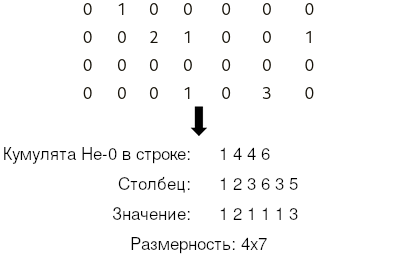



Здесь хранится информация о том, сколько суммарно ненулевых элементов в данной строке и выше, индексы столбцов с ненулевыми значениями, сами значения и размерность матрицы.

* В первой строке обозначено, сколько накоплено ненулевых значений (в первой строке — суммарно 1, после второй строки — суммарно 4, после третьей строки — суммарно 4, после четвёртой строки — суммарно 6).
* Во второй строке показано, в каком столбце находится ненулевое значение.
* В третьей строке указаны сами значения.

Осуществляем преобразование следующим образом:



In [ ]:
# Передаём в качестве аргументов в функцию выставленный рейтинг (это будут значения матрицы),
# а также id пользователя и id книги (это будут индексы для строк и столбцов матрицы)
ratings_matrix = csr_matrix((ratings.rating,(ratings.user_id,ratings.book_id)))


Теперь нам необходимо составить матрицу с метаданными. В качестве индексов будут выступать `id` книги и `id` тега, и если у этой книги есть рассматриваемый тег, то на пересечении соответствующих строки и столбца будет выставлена единица.



In [ ]:
meta_matrix  = csr_matrix(([1]*len(book_tags),(book_tags.id,book_tags.tag_id)))


In [ ]:
ratings_matrix.mean()

0.007086188900997592

Отлично, данные подготовлены — теперь настало время определить модель, которую мы будем использовать. Сделаем это следующим образом:



In [ ]:
model = LightFM(
    loss='warp-kos', # Определяем функцию потерь
    random_state=42, # Фиксируем случайное разбиение
    learning_rate=0.05, # Темп обучения
    no_components=100 # Размерность вектора для представления данных в модели
)


В качестве функции потерь мы выбрали значение `'warp'`, хотя, разумеется, это не единственный вариант. В модуле `LightFM` представлены следующие функции потерь:

* `'logistic'` — логистическая функция. Полезна в случаях, когда есть как положительные, так и отрицательные взаимодействия, например 1 и -1.
* `'bpr'` — байесовский персонализированный рейтинг. Можно применять, когда присутствуют только положительные взаимодействия.
* `'warp'` — парный взвешенный приблизительный ранг. Используется, если необходимо повысить качество именно в верхней части списка рекомендаций.
* `'warp-kos'` — модификация warp.

Разобьём данные на обучающую и тестовую выборки:

In [ ]:
train, test = random_train_test_split(
    ratings_matrix, # Общая выборка
    test_percentage=0.2, # Размер тестовой выборки
    random_state=42 # Генератор случайных чисел
)

Теперь обучим модель на наших данных о взаимодействии, также используя метаданные о книгах. Для этого воспользуемся методом `fit()`. В этот метод передадим обучающую выборку, признаки товаров — `item_features`, количество эпох обучения (сколько раз мы будем показывать модели исходный датасет, чтобы она лучше выучила данные) — `epochs`, а также параметр `verbose` для отслеживания процесса обучения:

In [ ]:
model = model.fit(
    train, # Обучающая выборка
    item_features=meta_matrix, # Признаки товаров
    epochs=10, # Количество эпох
    verbose=True # Отображение обучения
)

Epoch: 100%|██████████| 10/10 [11:52<00:00, 71.24s/it]


Оцените качество полученной модели с помощью функции `precision_at_k`, передав в неё три аргумента: модель, тестовые данные и обозначение метаданных (`item_features = meta_matrix`).



In [ ]:
precision_at_k(model, test, item_features=meta_matrix, num_threads=12).mean()

В рекомендательных системах метрики интерпретируются иначе, чем в задачах классификации. Показатели точности РС считаются хорошими, если они находятся в районе 0.1-0.3.

У нас получился не слишком высокий, но довольно неплохой результат. Чтобы его улучшить, можно попробовать следующее:

* Поработать над предобработкой данных, добавив в них дополнительную информацию о товарах. Также можно попробовать воспользоваться иным способом создания разреженной матрицы, например, форматом `coo_matrix()` или `csc_matrix()`, которые также входят в библиотеку `scipy`. Подробнее почитать о них вы можете [здесь](https://python-school.ru/blog/sparse-matrix-scipy/).
* Поиграться с параметрами модели `LightFM` — поуправлять темпом обучения (`learning_rate`), размерностью вектора для представления (`no_components`), количеством эпох обучения (`epochs`) и функцией потерь (`loss`).


>Для предсказания рейтинга нового пользователя можно воспользоваться методом `predict()`:

`scores = model.predict(<индекс интересующего пользователя>, np.arange(n_items), user_features=new_user_feature)`

|Преимущества|Недостатки|
|-|-|
|Использование разных моделей позволяет компенсировать их недостатки и использовать преимущества каждой модели для составления рекомендаций.|Такие модели обычно имеют высокую вычислительную сложность и из-за этого долго обучаются.|
|Благодаря использованию сразу нескольких методов такой подход позволяет получить более персонализированные и точные рекомендации.|Для обучения таких моделей требуются большие объёмы данных и поступление новых данных для обновления рекомендаций.|